In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from math import ceil

In [2]:
start = datetime.fromisoformat('2016-01-01T00:00:00')
end = datetime.fromisoformat('2024-03-02T00:00:00')

days = (end - start).days
intervals = ceil(days / 300)
interval = timedelta(days=300)

results = []

for i in range(0, intervals):
    s = start + (i * interval)
    e = s + interval
    if e > end:
        e = end

    print(f'{s} -> {e}')
    
    params = {
        'start': s,
        'end': e,
        'granularity': 86400,
    }
    
    res = requests.get('https://api.exchange.coinbase.com/products/BTC-USD/candles', params=params)
    results.extend(res.json())


2016-01-01 00:00:00 -> 2016-10-27 00:00:00
2016-10-27 00:00:00 -> 2017-08-23 00:00:00
2017-08-23 00:00:00 -> 2018-06-19 00:00:00
2018-06-19 00:00:00 -> 2019-04-15 00:00:00
2019-04-15 00:00:00 -> 2020-02-09 00:00:00
2020-02-09 00:00:00 -> 2020-12-05 00:00:00
2020-12-05 00:00:00 -> 2021-10-01 00:00:00
2021-10-01 00:00:00 -> 2022-07-28 00:00:00
2022-07-28 00:00:00 -> 2023-05-24 00:00:00
2023-05-24 00:00:00 -> 2024-03-02 00:00:00


In [3]:
len(results)

2984

In [5]:
# [timestamp, price_low, price_high, price_open, price_close]

rows = [{'day': datetime.fromtimestamp(r[0]).date(), 'low': r[1], 'high': r[2], 'open': r[3], 'close': r[4], 'volume': r[5]} for r in results]
coinbase = pd.DataFrame.from_dict(rows)
coinbase.to_csv('coinbase.csv', index=False)

In [6]:
#coinbase = pd.DataFrame(rows)
coinbase = pd.read_csv('bitcoin.csv')
coinbase.head()

,day,low,high,open,close,volume
0,2016-01-01,432.41,437.56,435.67,435.40,3276.709621
1,2016-01-02,425.02,435.75,435.40,431.91,3904.335318
2,2016-01-03,431.37,435.79,431.90,433.85,5894.445723
3,2016-01-04,430.00,435.64,433.84,433.34,5150.109476
4,2016-01-05,428.15,433.46,433.32,430.87,5476.959959


In [7]:
coinbase['day'] = pd.to_datetime(coinbase.day)
coinbase = coinbase.set_index('day', drop=True)

In [8]:
coinbase = coinbase.sort_index()

<Axes: xlabel='day'>

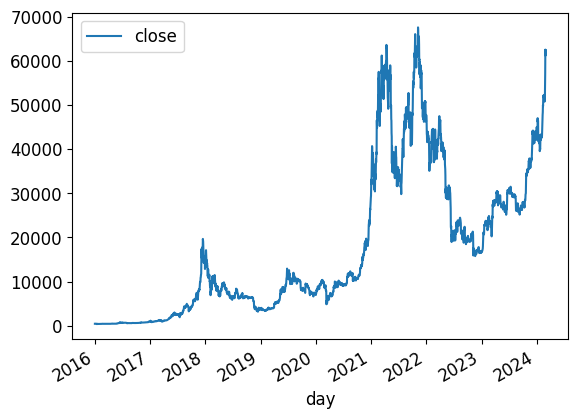

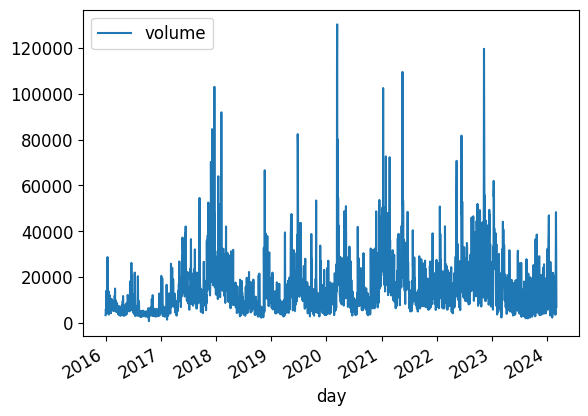

In [15]:
import matplotlib.pyplot as plt

coinbase.plot(y='close', use_index=True)
coinbase.plot(y='volume', use_index=True)

<Axes: xlabel='close', ylabel='volume'>

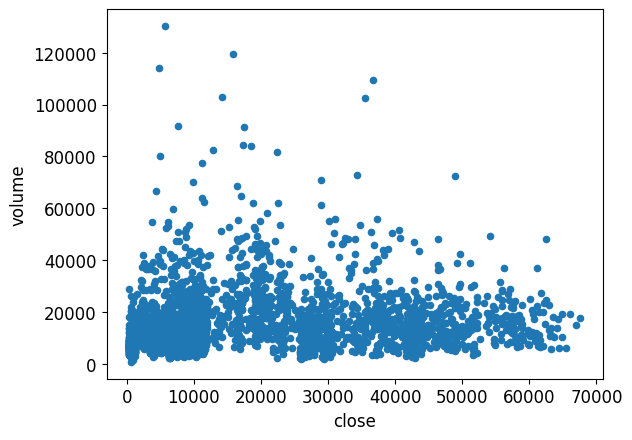

In [16]:
coinbase.plot.scatter('close', 'volume')

In [53]:
coinbase.to_csv('bitcoin.csv', index=False)

In [135]:
coinbase.head()

,low,high,open,close,volume,idr,change,change_abs,day
day,,,,,,,,,
2016-01-01,432.41,437.56,435.67,435.40,3276.709621,5.15,0.27,0.27,2016-01-01
2016-01-02,425.02,435.75,435.40,431.91,3904.335318,10.73,3.49,3.49,2016-01-02
2016-01-03,431.37,435.79,431.90,433.85,5894.445723,4.42,-1.95,1.95,2016-01-03
2016-01-04,430.00,435.64,433.84,433.34,5150.109476,5.64,0.50,0.50,2016-01-04
2016-01-05,428.15,433.46,433.32,430.87,5476.959959,5.31,2.45,2.45,2016-01-05


In [138]:
from itertools import product
from datetime import timedelta

# get all months and years
years = list(set([year for year in coinbase.day.dt.year]))
months = list(set([month for month in coinbase.day.dt.month]))

results = []

yearmonths = product(months, years)
for month, year in yearmonths:
    df = coinbase[(coinbase.day.dt.year == year) & (coinbase.day.dt.month == month)]
    if df.empty:
        print(f'Empty for {month}/{year}')
        continue
    try:
        month_open = df.iloc[0].open
        month_close = df.iloc[-1].close


        results.append({
            'month': month,
            'year': year,
            'open': month_open,
            'close': month_close,
            'change': round(month_close - month_open, 2),
            'total_volume': df.volume.sum()
        })
    except Exception as e:
        print(e)
        print(df)

Empty for 4/2024
Empty for 5/2024
Empty for 6/2024
Empty for 7/2024
Empty for 8/2024
Empty for 9/2024
Empty for 10/2024
Empty for 11/2024
Empty for 12/2024


In [139]:
monthly = pd.DataFrame(results)
monthly.head()

,month,year,open,close,change,total_volume
0,1,2016,435.67,371.33,-64.34,257289.648368
1,1,2017,992.96,992.75,-0.21,228502.615609
2,1,2018,13480.00,9014.23,-4465.77,674771.193205
3,1,2019,3826.10,3437.50,-388.60,283673.593296
4,1,2020,7174.33,9380.18,2205.85,332090.794177


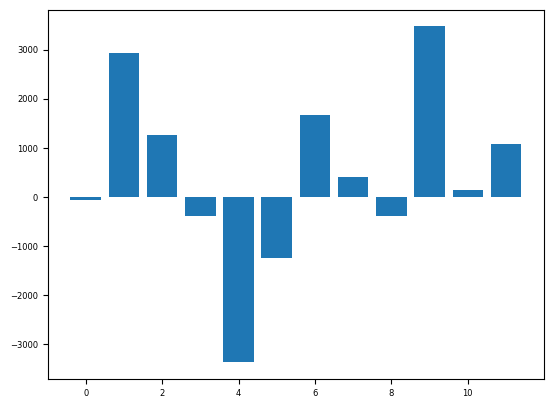

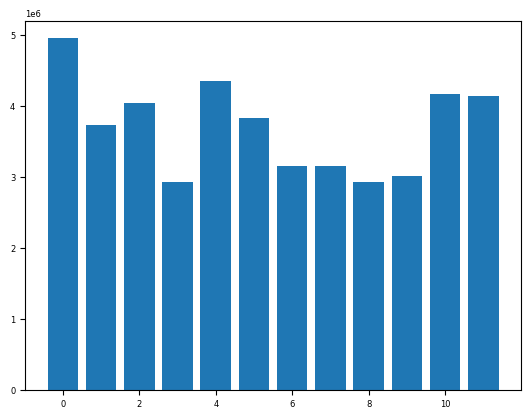

In [144]:
change_means = []
volume_means = []
for month in monthly.month.unique():
    monthly_mean = monthly[(monthly.month == month) & (monthly.year != 2024)].change.mean()
    volume_mean = monthly[(monthly.month == month) & (monthly.year != 2004)].total_volume.sum()
    change_means.append(monthly_mean)
    volume_means.append(volume_mean)
    
plt.bar(range(0, 12), change_means)
plt.show()
plt.bar(range(0, 12), volume_means)
plt.show()